In [1]:
#Mediante https://www.tensorflow.org/tutorials/structured_data/time_series
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow.keras import layers
from keras.layers import Dense,LSTM
from keras.models import Sequential, Model
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Using TensorFlow backend.


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [3]:
dataMeteoCellId5644 = pd.read_csv('transformed_data/mi_CellId_extra_info_10min_December_5644.csv', index_col=0)
dataMeteoCellId5644

,week,weekday,hour,minute,CellID,smsin,smsout,callin,callout,internet,idx,relativeHumidity,precipitation,temperature,windSpeed,CO,NO2,NO,Benzene
74,48,6,1,0,5644,4.212775,1.955709,0.388609,0.953972,135.029209,49254.0,99.0,0.0,-0.200000,0.366667,1.200000,57.900000,124.500000,0.071660
80,48,6,1,10,5644,1.799319,0.605493,0.898670,0.299133,107.493371,49255.0,99.0,0.0,-0.283333,0.405556,1.216667,58.866667,124.683333,0.075489
86,48,6,1,20,5644,1.990377,0.354464,0.331425,0.129266,116.361533,49256.0,99.0,0.0,-0.366667,0.444444,1.233333,59.833333,124.866667,0.079317
92,48,6,1,30,5644,0.240589,0.118954,0.967023,0.070730,127.892932,49257.0,99.0,0.0,-0.450000,0.483333,1.250000,60.800000,125.050000,0.083146
98,48,6,1,40,5644,2.553785,0.337123,1.610132,0.000000,110.755299,49258.0,99.0,0.0,-0.533333,0.522222,1.266667,61.766667,125.233333,0.086974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24242,52,6,0,20,5644,4.983078,4.126058,0.000000,1.587627,170.734492,53282.0,99.0,0.0,6.733333,1.100000,1.500000,51.700000,88.500000,1.200000
24248,52,6,0,30,5644,3.779156,2.233179,0.043089,0.000000,153.487745,53283.0,99.0,0.0,6.700000,1.100000,1.500000,51.950000,86.500000,1.200000
24254,52,6,0,40,5644,2.582291,3.227843,1.745399,1.056442,157.522089,53284.0,99.0,0.0,6.666667,1.100000,1.500000,52.200000,84.500000,1.200000
24260,52,6,0,50,5644,3.701950,3.957995,1.199242,0.000000,159.975281,53285.0,99.0,0.0,6.633333,1.100000,1.500000,52.450000,82.500000,1.200000


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644)

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 2823 #len(dataMeteoCellId5644) * 0.7

In [7]:
TRAIN_SPLIT

2823

In [8]:
tf.random.set_seed(0)

In [9]:
uni_data5644 = dataMeteoCellId5644['internet']
uni_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
uni_data5644.head()

idx
2166.0    135.029209
2167.0    107.493371
2168.0    116.361533
2169.0    127.892932
2170.0    110.755299
Name: internet, dtype: float64

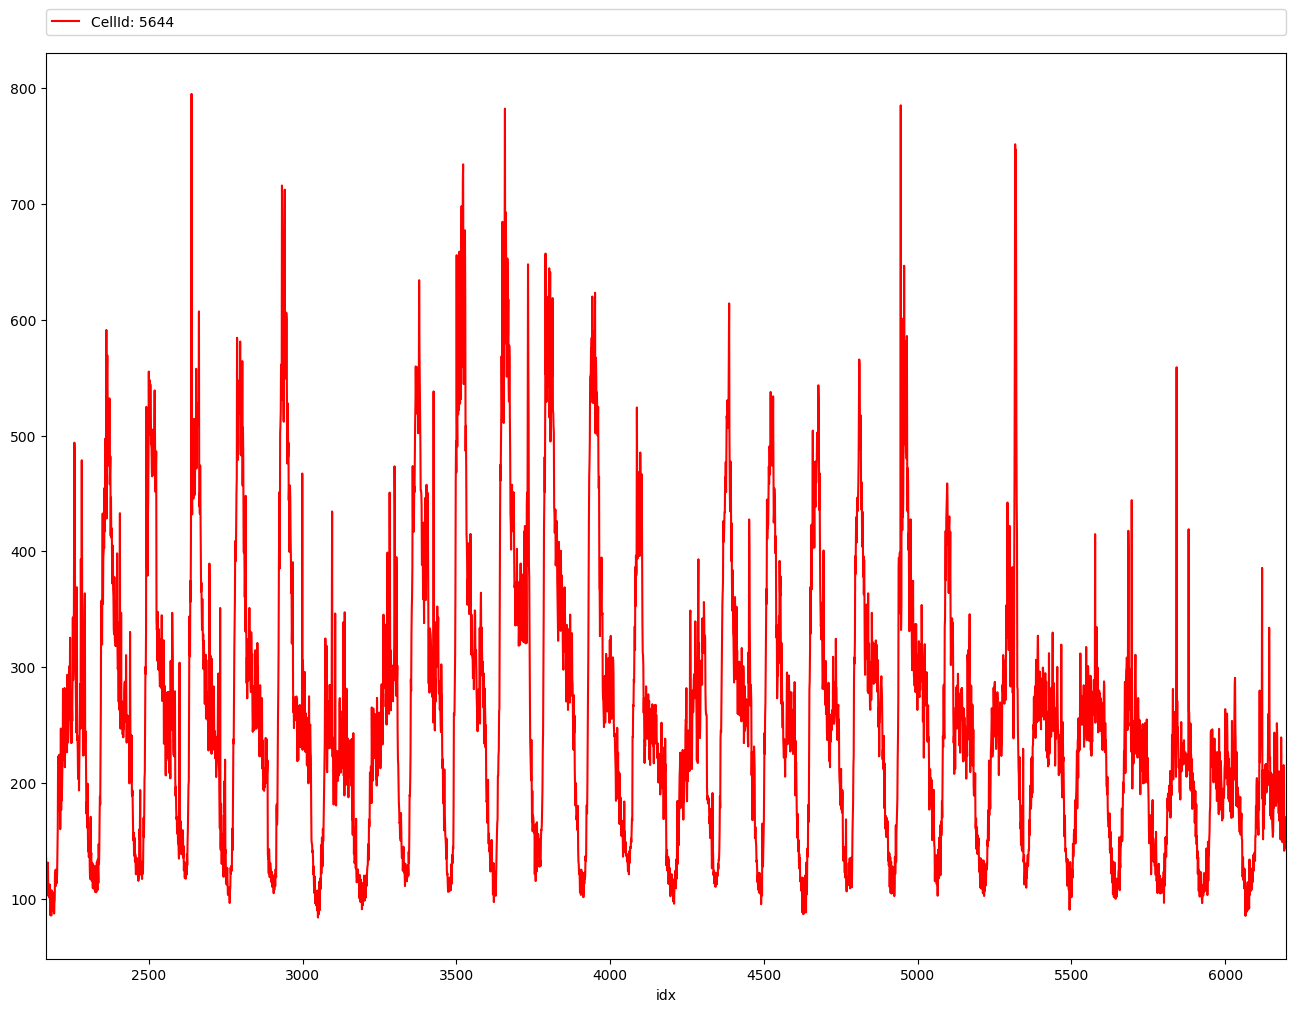

In [10]:
plt.figure(figsize=(16, 12), dpi=100) 

uni_data5644.plot(kind='line',x='index',y='internet', color='red', label = "CellId: 5644")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('Prueba.png',bbox_inches='tight')

plt.show()

In [11]:
uni_data = uni_data5644

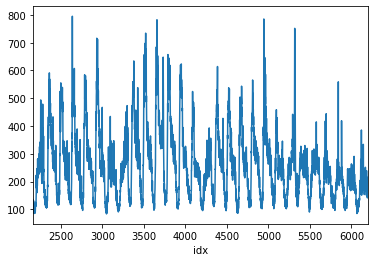

In [12]:
uni_data.plot()

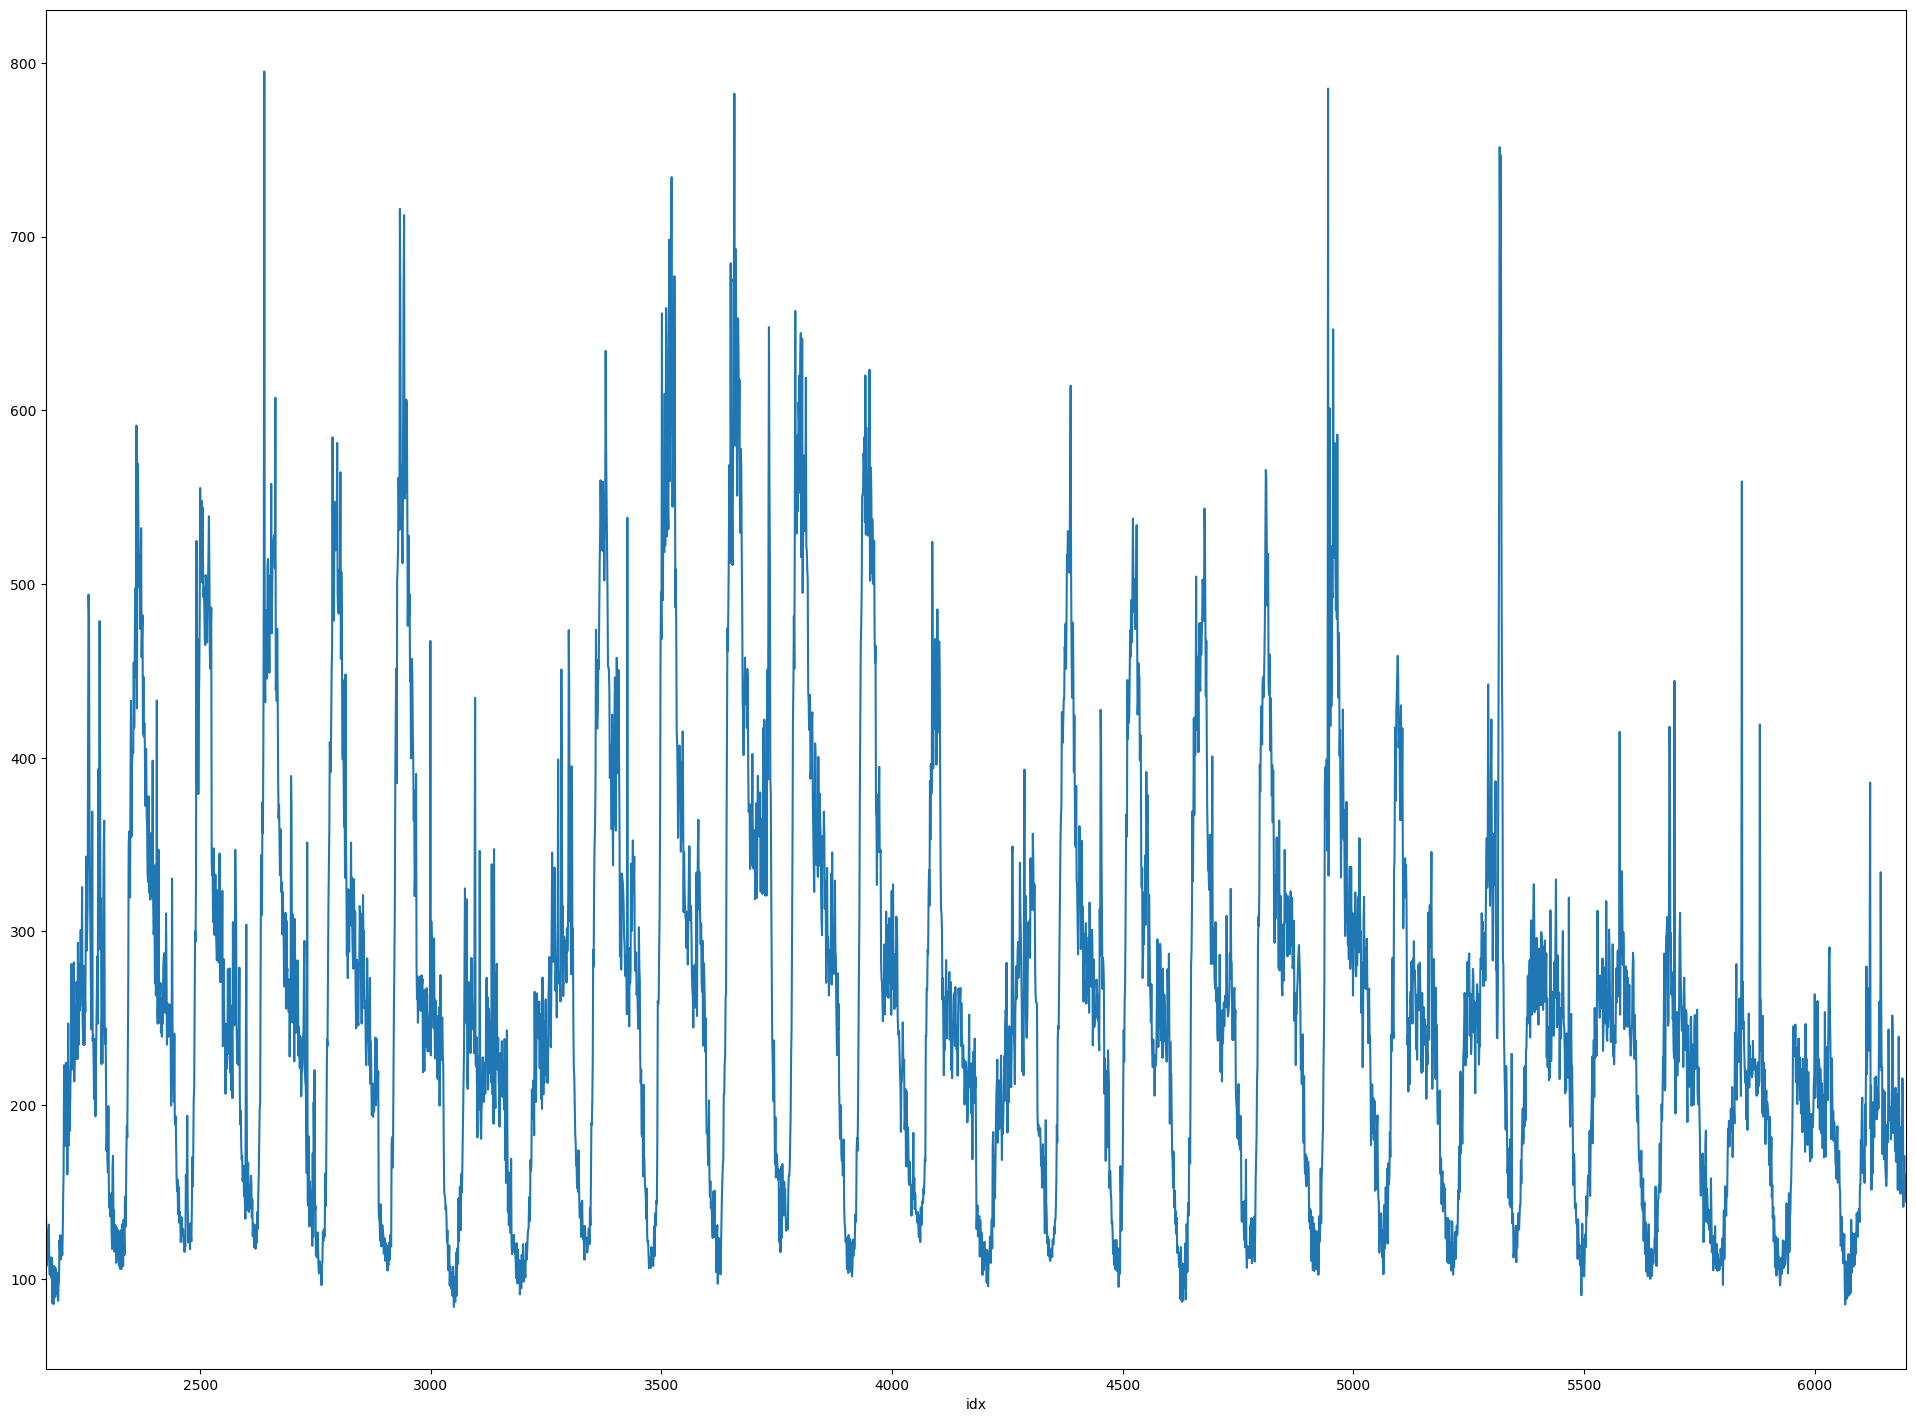

In [13]:
plt.figure(figsize=(24, 18), dpi=100) 
uni_data.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba5644.png',bbox_inches='tight')
plt.show()

In [14]:
uni_data

idx
2166.0    135.029209
2167.0    107.493371
2168.0    116.361533
2169.0    127.892932
2170.0    110.755299
             ...    
6194.0    170.734492
6195.0    153.487745
6196.0    157.522089
6197.0    159.975281
6198.0    144.458604
Name: internet, Length: 4033, dtype: float64

In [15]:
uni_data = uni_data.values

In [16]:
uni_data

array([135.02920893, 107.49337135, 116.36153292, ..., 157.52208874,
       159.97528053, 144.45860365])

In [17]:
uni_data
len(uni_data)

4033

In [18]:
from sklearn.preprocessing import MinMaxScaler
feature = ['idx', 'internet']
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644[feature])

In [19]:
uni_data = DataScaledMeteoCellId5644

In [20]:
uni_data

array([[0.00000000e+00, 7.19307606e-02],
       [2.48015873e-04, 3.32120867e-02],
       [4.96031746e-04, 4.56817802e-02],
       ...,
       [9.99503968e-01, 1.03558434e-01],
       [9.99751984e-01, 1.07007914e-01],
       [1.00000000e+00, 8.51896149e-02]])

In [21]:
uni_data[:,1]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [22]:
univariate_past_history = 6
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data[:,1], 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data[:,1], TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [23]:
len(x_train_uni)

2817

In [24]:
len(y_train_uni)

2817

In [25]:
len(x_val_uni)

1203

In [26]:
x_train_uni

array([[[0.07193076],
        [0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265]],

       [[0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302]],

       [[0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302],
        [0.03359665]],

       ...,

       [[0.40235302],
        [0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ]],

       [[0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927]],

       [[0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927],
        [0.30988734]]])

In [27]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Internet charge to predict')
print (y_train_uni[0])

Single window of past history
[[0.07193076]
 [0.03321209]
 [0.04568178]
 [0.0618963 ]
 [0.03779875]
 [0.04907265]]

 Target Internet charge to predict
0.03359665147127812


In [28]:
def create_time_steps(length):
    return list(range(-length, 0))

In [29]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+3)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'E:\\Python\\TensorFlow\\lib\\site-packages\\matplotlib\\pyplot.py'>

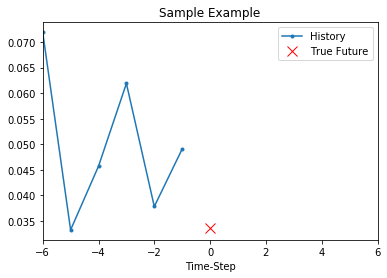

In [30]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'E:\\Python\\TensorFlow\\lib\\site-packages\\matplotlib\\pyplot.py'>

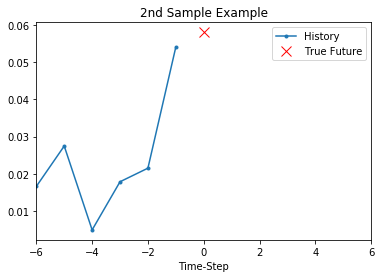

In [31]:
show_plot([x_train_uni[24], y_train_uni[24]], 0, '2nd Sample Example')

In [32]:
import requests

def telegram_bot_sendtext(bot_message):
    
    bot_token = '1441415905:AAGslC5ZnjlBYHnFYP-9KAH-BPAwnqJc1X4'
    bot_chatID = '1071238666'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()
    
maquina = "VM 5644-6-0-1"
    
test = telegram_bot_sendtext(maquina + " reiniciada")
print(test)

{'ok': True, 'result': {'message_id': 1837, 'from': {'id': 1441415905, 'is_bot': True, 'first_name': 'Tfmbot', 'username': 'Tfmdl_bot'}, 'chat': {'id': 1071238666, 'first_name': 'man', 'last_name': 'cham', 'username': 'mancham8', 'type': 'private'}, 'date': 1609958341, 'text': 'VM 5644-6-0-1 reiniciada'}}


# LR GLOBAL

In [33]:
LR_GLOBAL = 0

# Recurrent neural network con cambio de variables con la CellId 5644 -LSTM

In [34]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 16)             1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)         

In [35]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5644-6-0-1-mse_LSTM_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [36]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
dfModel5644ArrayAcc.to_csv('transformed_data/model5644-6-0-1-acc_LSTM_' + str(LR_GLOBAL).zfill(1) + '.csv', encoding='utf-8')

In [37]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Single MSE LSTM")

# Recurrent neural network con cambio de variables con la CellId 5644 - GRU

In [38]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 6, 16)             912       
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)             

In [39]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5644-6-0-1-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileGruMulti2, encoding='utf-8')

In [40]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Single MSE GRU")

In [41]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
dfModel5644ArrayAcc.to_csv('transformed_data/model5644-6-0-1-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv', encoding='utf-8')

# Recurrent neural network con cambio de variables con la CellId 5644 multivariate time series

In [42]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [43]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
2166.0,-0.200000,99.0,0.0,0.366667,135.029209
2167.0,-0.283333,99.0,0.0,0.405556,107.493371
2168.0,-0.366667,99.0,0.0,0.444444,116.361533
2169.0,-0.450000,99.0,0.0,0.483333,127.892932
2170.0,-0.533333,99.0,0.0,0.522222,110.755299


In [44]:
len(multi_data5644)

4033

In [45]:
dataset = multi_data5644.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

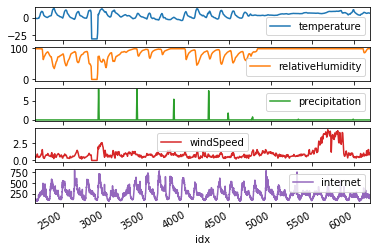

In [46]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [47]:
multi_data5644

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
2166.0,-0.200000,99.0,0.0,0.366667,135.029209
2167.0,-0.283333,99.0,0.0,0.405556,107.493371
2168.0,-0.366667,99.0,0.0,0.444444,116.361533
2169.0,-0.450000,99.0,0.0,0.483333,127.892932
2170.0,-0.533333,99.0,0.0,0.522222,110.755299
...,...,...,...,...,...
6194.0,6.733333,99.0,0.0,1.100000,170.734492
6195.0,6.700000,99.0,0.0,1.100000,153.487745
6196.0,6.666667,99.0,0.0,1.100000,157.522089


In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [49]:
dataset = DataScaledMeteoCellId5644

In [50]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [51]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [52]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [53]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [54]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [55]:
x_train_multi[0]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       [0.67391304, 1.        , 0.        , 0.10902256, 0.0618963 ],
       [0.6720061 , 1.        , 0.        , 0.11779449, 0.03779875],
       [0.67009916, 1.        , 0.        , 0.12656642, 0.04907265]])

In [56]:
y_train_multi[0]

0.03359665147127812

In [57]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)

                #model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], simple_lstm, history_lstm])
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 16)             1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)         

In [58]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5644multi-6-0-1-TRPW-mse_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [59]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse LSTM")

In [60]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmMulti = 'transformed_data/model5644multi-6-0-1-TRPW-acc_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644ArrayAcc.to_csv(fileLstmMulti, encoding='utf-8')

In [61]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc LSTM")

# Recurrent neural network con cambio de hiperparametros con la CellId 5644 multivariate time series - GRU

In [62]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [63]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
2166.0,-0.200000,99.0,0.0,0.366667,135.029209
2167.0,-0.283333,99.0,0.0,0.405556,107.493371
2168.0,-0.366667,99.0,0.0,0.444444,116.361533
2169.0,-0.450000,99.0,0.0,0.483333,127.892932
2170.0,-0.533333,99.0,0.0,0.522222,110.755299


In [64]:
len(multi_data5644)

4033

<Figure size 2400x1800 with 0 Axes>

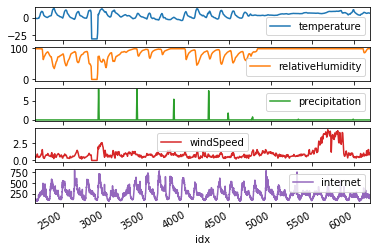

In [65]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [66]:
multi_data5644

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
2166.0,-0.200000,99.0,0.0,0.366667,135.029209
2167.0,-0.283333,99.0,0.0,0.405556,107.493371
2168.0,-0.366667,99.0,0.0,0.444444,116.361533
2169.0,-0.450000,99.0,0.0,0.483333,127.892932
2170.0,-0.533333,99.0,0.0,0.522222,110.755299
...,...,...,...,...,...
6194.0,6.733333,99.0,0.0,1.100000,170.734492
6195.0,6.700000,99.0,0.0,1.100000,153.487745
6196.0,6.666667,99.0,0.0,1.100000,157.522089


In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [68]:
dataset = DataScaledMeteoCellId5644

In [69]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [70]:
len(dataset)

4033

In [71]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [72]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [73]:
dataset #dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [74]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [75]:
len(x_train_multi)

2817

In [76]:
len(x_val_multi)

1203

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 6, 16)             912       
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)             

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5644multi-6-0-1-TRPW-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileGruMulti2, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse GRU")

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruMulti = 'transformed_data/model5644multi-6-0-1-TRPW-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644ArrayAcc.to_csv(fileGruMulti, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc GRU")

# Recurrent neural network con cambio de variables con la CellId 5644 multivariate time series SEPARADO

In [ ]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [ ]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

In [ ]:
len(multi_data5644)

In [ ]:
dataset = multi_data5644.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [ ]:
multi_data5644

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [ ]:
dataset = DataScaledMeteoCellId5644

In [ ]:
dataset

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
dataset[:, 4]

In [ ]:
dataset[:, [0,1,2,3]]

In [ ]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
x_train_multi[0]

In [ ]:
y_train_multi[0]

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5644multi-6-0-1-TRPW-sep-mse_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse LSTM")

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmMulti = 'transformed_data/model5644multi-6-0-1-TRPW-sep-acc_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644ArrayAcc.to_csv(fileLstmMulti, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc LSTM")

# Recurrent neural network con cambio de hiperparametros con la CellId 5644 multivariate time series - GRU SEPARADO

In [ ]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [ ]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

In [ ]:
len(multi_data5644)

In [ ]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [ ]:
multi_data5644

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [ ]:
dataset = DataScaledMeteoCellId5644

In [ ]:
dataset

In [ ]:
len(dataset)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
dataset[:, 4]

In [ ]:
dataset[:, [0,1,2,3]]

In [ ]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
len(x_train_multi)

In [ ]:
len(x_val_multi)

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5644multi-6-0-1-TRPW-sep-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644mse.to_csv(fileGruMulti2, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse GRU")

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruMulti = 'transformed_data/model5644multi-6-0-1-TRPW-sep-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5644ArrayAcc.to_csv(fileGruMulti, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc GRU")

# Comparacion de datos

## Datos LSTM Model 5644

In [122]:
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644acc_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644mse_1_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

FileNotFoundError: [Errno 2] File b'transformed_data/model5644acc_1_1.csv' does not exist: b'transformed_data/model5644acc_1_1.csv'

In [ ]:
singleModel5644Acc

In [ ]:
singleModel5644Mse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [ ]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644Mse[singleModel5644Mse['mse'] < 0.029]

In [ ]:
idxMse.max()

In [ ]:
singleModel5644Mse[singleModel5644Mse['mse'] > 0.0443]

## Datos LSTM Model 5644 - GRU

In [ ]:
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644acc_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644mse_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

In [ ]:
singleModel5644AccGRU

In [ ]:
singleModel5644AccGRU.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [ ]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644mse_gru.csv', encoding='utf-8')

In [ ]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [ ]:
idxMseGRU

In [ ]:
idxMseGRU.min()

In [ ]:
singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.0279]

In [ ]:
idxMseGRU.max()

In [ ]:
singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.04502]

## Datos LSTM TRPW Model 5644 (no separarados)

In [ ]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    print ('transformed_data/model5644multi-6-0-1-TRPW-acc_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-acc_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-mse_1_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPW-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0273]

In [ ]:
idxMse.max()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0445]

## Datos LSTM TRPW Model 5644 (separarados)

In [ ]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-sep-acc_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-sep-mse_1_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPW-sep-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0261]

In [ ]:
idxMse.max()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03875]

## Datos GRU TRPW Model 5644 (no separarados)

In [ ]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-acc_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-mse_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWMse

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPW-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0276]

In [ ]:
idxMse.max()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0456]

## Datos GRU TRPW Model 5644 (separarados)

In [ ]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-sep-acc_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPW-sep-mse_GRU_1_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPW-sep-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02685]

In [ ]:
idxMse.max()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0423]

In [ ]:
idxAccGRU.max()

In [ ]:
singleModel5644AccGRU[singleModel5644AccGRU['keras_model_acc'] > 0.41]

# Comparacion de datos 12-0-6

## Datos LSTM Model 5644 12-0-6

In [ ]:
#OK
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644acc-12-0-6_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644mse-12-0-6_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

In [ ]:
singleModel5644Acc

In [ ]:
singleModel5644Mse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [ ]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644mse-12-0-6_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644Mse[singleModel5644Mse['mse'] < 0.0285]

In [ ]:
tabla1.to_excel("model5644mse-12-0-6_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644Mse[singleModel5644Mse['mse'] > 0.03822]

In [ ]:
tabla2.to_excel("model5644mse-12-0-6_lstm_max.xlsx")

In [ ]:
singleModel5644Mse['mse'].mean()

## Datos LSTM Model 5644 - GRU 12-0-6

In [ ]:
#OK
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644acc-12-0-6-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644mse-12-0-6-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

In [ ]:
singleModel5644AccGRU

In [ ]:
singleModel5644AccGRU.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [ ]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644mse-12-0-6_gru.csv', encoding='utf-8')

In [ ]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [ ]:
idxMseGRU

In [ ]:
idxMseGRU.min()

In [ ]:
tabla1 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.0269]

In [ ]:
tabla1.to_excel("model5644mse-12-0-6_gru_min.xlsx")

In [ ]:
idxMseGRU.max()

In [ ]:
tabla2 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.0389]

In [ ]:
tabla2.to_excel("model5644mse-12-0-6_gru_max.xlsx")

In [ ]:
singleModel5644MseGRU['mse'].mean()

## Datos LSTM TRPW Model 5644 (no separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0273]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0399]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos LSTM TRPW Model 5644 (separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-sep-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02633]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-sep-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0395]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-sep-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (no separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWMse

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0272]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03958]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-sep-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02655]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-sep-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03651]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-sep-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

# Comparacion de datos 24-0-12

## Datos LSTM Model 5644 24-0-12

In [ ]:
#OK
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644acc-24-0-12_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644mse-24-0-12_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

In [ ]:
singleModel5644Acc

In [ ]:
singleModel5644Mse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [ ]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644mse-24-0-12_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644Mse[singleModel5644Mse['mse'] < 0.02629]

In [ ]:
tabla1.to_excel("model5644mse-24-0-12_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644Mse[singleModel5644Mse['mse'] > 0.0372]

In [ ]:
tabla2.to_excel("model5644mse-24-0-12_lstm_max.xlsx")

In [ ]:
singleModel5644Mse['mse'].mean()

## Datos LSTM Model 5644 - GRU 24-0-12

In [ ]:
#OK
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644acc-24-0-12-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644mse-24-0-12-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

In [ ]:
singleModel5644AccGRU

In [ ]:
singleModel5644AccGRU.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [ ]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644mse-24-0-12_gru.csv', encoding='utf-8')

In [ ]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [ ]:
idxMseGRU

In [ ]:
idxMseGRU.min()

In [ ]:
tabla1 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.026]

In [ ]:
tabla1.to_excel("model5644mse-24-0-12_gru_min.xlsx")

In [ ]:
idxMseGRU.max()

In [ ]:
tabla2 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.037955]

In [ ]:
tabla2.to_excel("model5644mse-24-0-12_gru_max.xlsx")

In [ ]:
singleModel5644MseGRU['mse'].mean()

## Datos LSTM TRPW Model 5644 (no separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02601]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0455]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos LSTM TRPW Model 5644 (separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-sep-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02576]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-sep-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.056]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-sep-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (no separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWMse

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02685]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03958]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-sep-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.025975]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-sep-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0559]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-sep-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

# Codigo para recuperarse de problemas con GPU

# gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])